<a href="https://colab.research.google.com/github/Nautyy9/expression_detection/blob/main/EXPRESSION_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

# Getting data from Kaggle API

In [ ]:
!pip install -q kaggle

In [ ]:
# is a shell command that creates a new directory named .kaggle in the home directory of the current user.

! mkdir ~/.kaggle

# copy kaggle.json to .kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# kaggle.json has user's Kaggle Api credentials to authenticate user
# By changing the permissions of the kaggle.json file to 600, the file can only be read and written by the owner of the file, which helps to protect the user's API credentials from unauthorized access

!chmod 600 /root/.kaggle/kaggle.json
# it is a shell command that changes the permissions of the kaggle.json file located in the /root/.kaggle/ directory.
# The chmod command is used to change the permissions of a file or directory in Unix-based systems.
# The 600 argument specifies the new permissions for the file, where 6 means that the owner of the file has read and write permissions, and no other users have any permissions

In [ ]:
# downloading from api
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 308M/309M [00:10<00:00, 30.7MB/s]
100% 309M/309M [00:10<00:00, 29.5MB/s]


In [ ]:
# unzipping from /content/human-emotions-datasethes.zip to our custom folder
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATASET INITAILIZATION

## CONFIGURATION

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory  = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
# the labelling inside the array is according to the directory to avoid accessing issue/index issues
Class_Names = ["angry", "happy","sad"]


CONFIG = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 20,
  "BATCH_SIZE": 32,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 256,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
  "PATCH_SIZE": 16,
  "PROJ_DIM": 768,
  "NUM_CLASSES": 3
}

#### **TRAINING_DATASET**

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_Names,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
    # validation_split0.2,
    # subset=validation_dataset,
    # interpolation='bilinear',
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # **kwargs
)

Found 6799 files belonging to 3 classes.


#### **VALIDATION_DATASET**

In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_Names,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
    # validation_split0.2,
    # subset=validation_dataset,
    # interpolation='bilinear',
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # **kwargs
)

Found 2278 files belonging to 3 classes.


# DATA VISUALIZATION

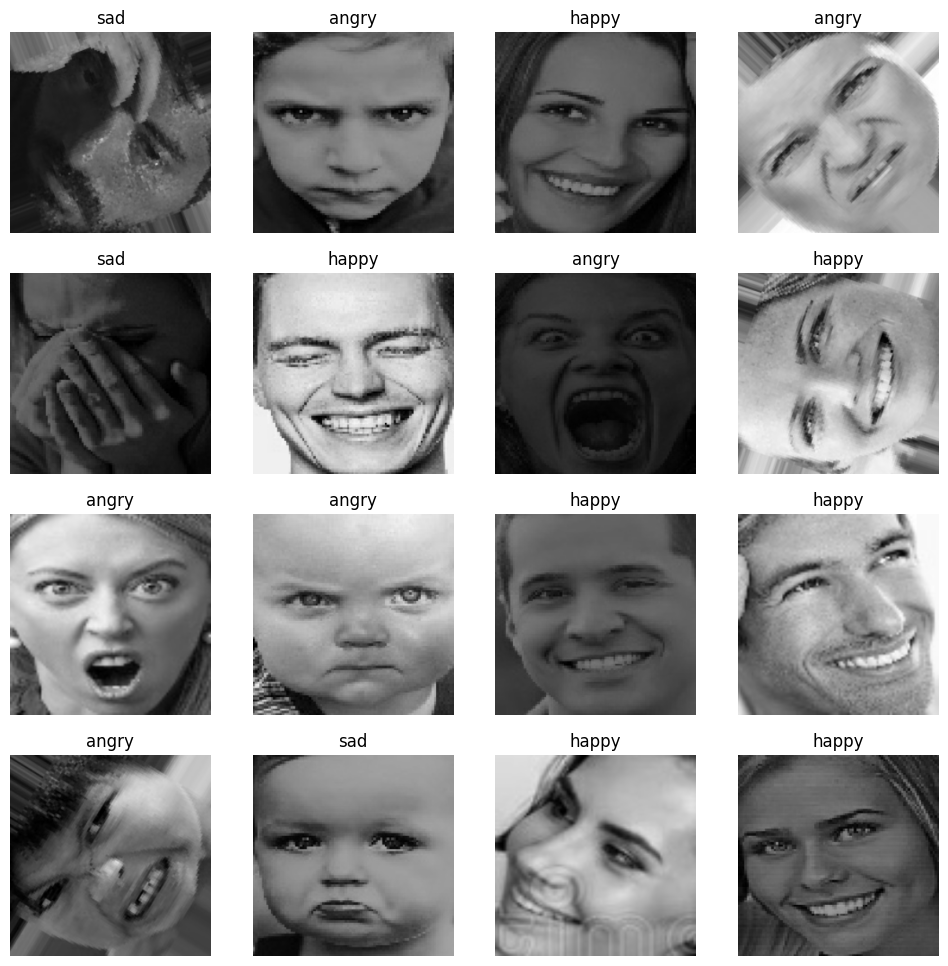

In [ ]:
plt.figure(figsize=(12,12))

for images, labels in train_dataset.take(1):
  # print(images, labels)
  for i  in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(Class_Names[tf.argmax(labels[i], axis =0,).numpy()])
    plt.axis("off")

# AUGMENTATION


In [ ]:
augement_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor= 0.1)
])

In [ ]:
def augement_layer(image,label):
  # sequential being called , returning the augmented image and the corresponding label
  return augement_layers(image, training = True),label

### **CUTMIX**


In [ ]:
# sample---> Generate samples of the specified shape. Note that a call to sample() without arguments will generate a single sample. Here we specified the shape == 1 and it returns a numpy array then we take that value with index 0

def box(lamda):
  r_x =tf.cast(tfp.distributions.Uniform(0, CONFIG["IM_SIZE"].sample(1)[0], dtype=tf.int32))
  r_y =tf.cast(tfp.distributions.Uniform(0, CONFIG["IM_SIZE"].sample(1)[0], dtype=tf.int32))

  r_w=tf.cast(CONFIG["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype= tf.int32)
  r_h=tf.cast(CONFIG["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype= tf.int32)

  # below gives x and y coordinate of image
  r_x = tf.clip_by_value(r_x + r_w//2 , 0, CONFIG["IM_SIZE"])
  r_y = tf.clip_by_value(r_y + r_h//2 , 0, CONFIG["IM_SIZE"])

  # this is useful to find the x and y coordinate of image when our image is half outside the box
  # the bottom right and the top  right corner(in case when our image is half outside from right side of box)
  x_b_r = tf.clip_by_value(r_x + r_w//2, 0 , CONFIG["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_w//2, 0 , CONFIG["IM_SIZE"])

  # since we find the top right and bottom right corner , now we want to clip our image for the part which is outside the box
  # changing the width and height of the image
  r_w = x_b_r - r_x
  if(r_w==0):
    # when our whole image is outside the box
    r_w = 1
  r_h =  y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Beta ke params --> concentration1 == alpha = mean * total_concentration, concentration0 == beta  = (1. - mean) * total_concentration
  # beta distributions are ranging from 0 to 1 , 2,2 are alpha and beta params
  lamda = tfp.distributions.Beta(2,2)
  lamda  = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

# cropping the second image and making it blank cropped section

  # Crops an image to a specified bounding box. This op cuts a rectangular bounding box out of image. The top-left corner of the bounding box is at offset_height, offset_width in image, and the lower-right corner is at
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  # Pad image with zeros to the specified height and width, i.e, we are filling that cropped section with zeros hence we see a black cropped box
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIG["IM_SIZE"], CONFIG["IM_SIZE"])

# cutting img from the first one to make it fit in second image
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIG["IM_SIZE"], CONFIG["IM_SIZE"])

  # making a new image out of cut mixing two images

  image = image_1 - pad_1 + pad_2

  # creating new image lamda and label ,
  lamda = tf.cast(1- (r_w*r_h)/(CONFIG["IM_SIZE"]*CONFIG["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label


In [ ]:
alpha = [1, 2, 3]
beta = [1, 2, 3]
dist = tfp.distributions.Beta(2, 2)
print(dist.sample(1))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


tf.Tensor([0.5933883], shape=(1,), dtype=float32)


# DATASET PREPARATION


In [ ]:
# batching and shuffling is done in the tf.keras.utils.image_dataset_from_directory
# hence we don't do batching and shuffling again

# train_dataset
# val_dataset


train_dataset = (
    train_dataset
    # .map(augement_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# since we've created a layer thef we can directly put this inside our model and we don't need to resize and rescale dataset in above training and validation dataset

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIG["IM_SIZE"], CONFIG["IM_SIZE"]),
    # each pixel value in an image is divided by 255 to scale the pixel values to the range
    Rescaling(1./255)
])

# In the context of image processing, pixel values are typically represented as integers in the range [0, 255]. However, many machine learning algorithms require input data to be in a specific range, such as
#  [-1, 1]. Rescaling the pixel values to the desired range can help to improve the performance of the machine learning algorithm
#  The code 1./255 is a simple way to rescale the pixel values of an image to the range
#  The division by 255 converts the integer pixel values to floating-point values between 0 and 1. For example, if a pixel value is 128, dividing it by 255 would result in a value of approximately 0.5.


# RECORDING THE DATA

unbatch

In [ ]:
# first we unbatch the our validation and training dataset

# for recording we've seen that the data is stored in form of protocol buffers and the process of conversion of data to protocol buffer is done by tf.train.Example
# now this Example class/method takes in a features which in turn contain  multiple feature which can of diff types(int, bytes or float)
# Feature represent our current data while features represent multiple feature as a part in the shard(shard is the one of the part in which our main dataset is divided)


# For our model Feature type is int and bytes i.e, int for labels and bytes for the images
# putted these into the features which in turn is inside the Example
# then we return a serialized string as output


# our byte_list inside the bytes_feature is BytesList(value =[]) -> value must be list/array


In [ ]:
# we could've just print our recorded value to specified path but we've to deal with sharding and we've to define data for each shard, since each shard if used individually can define an entire model data
# now we need to create each shard , so we looped over shard number , then created shard dataset  . now our shard dataset require encoded images , our normal dataset won't work so we use tf.io.encode_jpeg
# still tf.io.encode_jpeg require an image of uint8 , but we've float so we use tf.image.conver_image_dtype
# finally returning the image and label from the encode_image function , we use this  to create encoded_data that use .map(ecode_image) -> mapping the dataset to encode function
# use this encode_dataset inside the shard_dataset which use .shard() method taking in the number of shards and current value of shard after this we've to return the value as iterator else error because our shard data is being looped over

# from our shard_dataset we are taking in encode_image and encode_label which we pass to our example_function()
# then using file_writer which we alias for tf.io.TFRecordWriter() taking in each shard as name, we write to each shard the serialized string returned by the example_funtion

# now we can save these file generated in our drive so we can use them for our training next time , without downloading the model

# now to use these files for training and validation dataset , we first convert them to tensorflow dataset from records using tf.data.TFRecord(filename)
# now this filename is the path of every file that saved our dataset .
# now we need to parse the data (i.e, for the Feature we've converted the images to  bytes and labels to int)-> to get our image back to the original format(image->uint8) from the format specified in Feature we use  tf.io.decode_image(image, channel) method, channel is for format (256,256,3)
# tf.io.parse_single_image used to generate the images and labels from the passed in example, but it require the feature_description  parameter that specify the format of the images and labels and return the example["images"] i.e, we passed image as example and then labels.


# finally creating new dataset (parsed_dataset) -> this take the data from tfRecord and map them using the example function, batch and prefetch autotune

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]

In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIG["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIG["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
for i in parsed_dataset.take(1):
  print(i)

NameError: ignored

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIG["N_FILTERS"] , kernel_size = CONFIG["KERNEL_SIZE"], strides = CONFIG["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIG["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIG["POOL_SIZE"], strides= CONFIG["N_STRIDES"]*2),
    Dropout(rate = CONFIG["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIG["N_FILTERS"]*2 + 4, kernel_size = CONFIG["KERNEL_SIZE"], strides=CONFIG["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIG["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIG["POOL_SIZE"], strides= CONFIG["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIG["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIG["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIG["DROPOUT_RATE"]),

    Dense( CONFIG['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIG["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIG["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
loss_function = CategoricalCrossentropy()

metrics = [CategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIG["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 3,
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

Epoch 1/3
117/213 [===============>..............] - ETA: 3:00 - loss: 1.0081 - accuracy: 0.5288

KeyboardInterrupt: ignored

Example contianing -> features -> feature

Shards and looping

# CREATING MODEL


*  The layers do not have any parameters to store the result of previous layers. This is because the layers are designed to be stateless. This means that the layers do not store any data between calls.
*   But,  In a sequential layer, the layers are chained together. This means that the output of the previous layer is passed to the next layer automatically.
*   Hence in class Based method we often sees some layer having double parenthesis because the result of it is not store in self keyword method




### **LENET MODEL**

In [ ]:
seq_model= tf.keras.Sequential([
    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,
    Conv2D(filters=CONFIG["N_FILTERS"], kernel_size=CONFIG["KERNEL_SIZE"], strides=CONFIG["N_STRIDES"], padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIG["POOL_SIZE"],strides=CONFIG["N_STRIDES"]*2),

    Conv2D(filters=CONFIG["N_FILTERS"]*2 +4 , kernel_size = CONFIG["KERNEL_SIZE"], strides=CONFIG["N_STRIDES"], padding="valid", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIG["POOL_SIZE"],strides=CONFIG["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIG["N_DENSE_1"], activation="relu"),
    BatchNormalization(),

    Dense(CONFIG["N_DENSE_2"], activation="relu"),
    BatchNormalization(),
    Dense(CONFIG["NUM_CLASSES"], activation="softmax"),
])

seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 16)    

### **RESNET MODEL**

*   Resnet is model in which we make residual blocks by collecting certain layers into one and other layers into another residual block
*   These blocks are parsed with i/p and the o/p generated by block is compared with the o/p by means of dotted line
* This dotted line then make difference between the i/p and o/p which give residue , then we pass that residual function to next block instead of only passing the output genereted by the previous block

**we send residual function to next layer == f(x)+x , where f(x) **

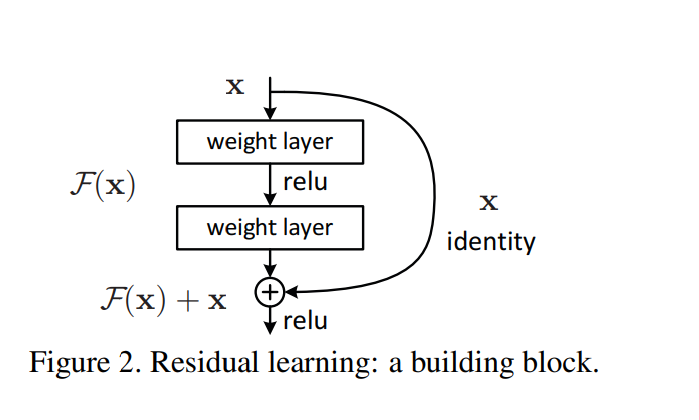

**dotted line === skip connection === shortcut connection**

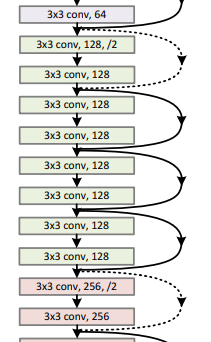

#### **CustomConv2D OR CONV LAYER OF RESNET**

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding='valid'):
    super(CustomConv2D, self).__init__(name = "custom_conv2d")

    self.conv = Conv2D(
        filters=n_filters,
        kernel_size= kernel_size,
        activation = "relu",
        strides = n_strides,
        padding = padding,
    )

    self.batch_norm = BatchNormalization()

  # training is the param which specify whether our mean and variance are learned with each dataset input or say each batch being send , if False then we will use the mean and variance that is learned during training
  # the training param , since we are talking about the mean and variance --> which are key aspect of Normalization , hence with mean and variance or say training we talk about normalization
  def call(self, x, training = True):
    # x is input training data
    x = self.conv(x)
    self.batch_norm(x, training)

  # returning normalized data
    return x

#### **RESIDUAL BLOCK OF RESNET**

In [ ]:
# we've dotted lines which connect the input data(may or may not be of block, but generally the input data is of block) with the output of the block
# this is done to make the comparision between the input and output hence to learn the residue which lead to get better results as we pass in the residual function(f(x)===output of prev block + x(the input of previous block)) to the next block instead of just the output data from the previous block
# this help in removing  vanishing gradient problem , since we know adding layers wouldn't increase the performance instead decrease it , this is bcz at certain no of layers our gradient become 0 and the layers will just increase the complexity without learning anything new
# the residual block dotted layer connect the input of block with output to get the residue(diff between i/p and o/p ) and we pass this residual function to next block so that our gradient can be tracked is become 0

# since the i/p and o/p of the block are of different shape ((1,256,256,64) ,(1,256,256, 128)) , thef we need to convert this batch to equal hence , only then we can compare
# to do that we've 2 method i.e, using patching i.e adding batching with expand_dims or another method which use the combined logic of the dot product with the filter of the channel and addition of 1x1 convolution having output channels i.e,
# ex -> i/p -> (1,256,256,1) to o/p -> (1,256,256,2) , to achieve this we must have to have a filter of 2  so 1 feature map multiplied by 2 filters result 2 output feature map (* we are not adding the value generated by each filter , for now we just made the feature map of two ,instead of adding) o/p -> (3,3,2) -> 3,3 is the filter size/kernel and 2 is output no of filters.i/p channel
# this 2 feature map is  added with 1x1 convolution of batch 2 i.e, (1,1,2, 2) ->( 1x1 convolution ,o/p of filters, o/p channel) ---> (3,3,2)*(1,1,2,2) --> which gives number of parameters


class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = "res_block")

    self.dotted = (n_strides != 1)
    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation("relu")

# found a dotted line hence creating a 1x1 convolution layer , since here our filter is 1
    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):
    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add  = self.custom_conv_3(input, training)
      # taking in conv layer and the output of the conv 2 layer which is our residual block
      x_add = Add()([x, x_add])
    else:
      # if there's no dotted line then we just add the output of residual block(conv_2_layer) and input from the previous block
      x_add = Add()([x, input])

    return self.activation(x_add)



#### **COMPLETE NETWORK**
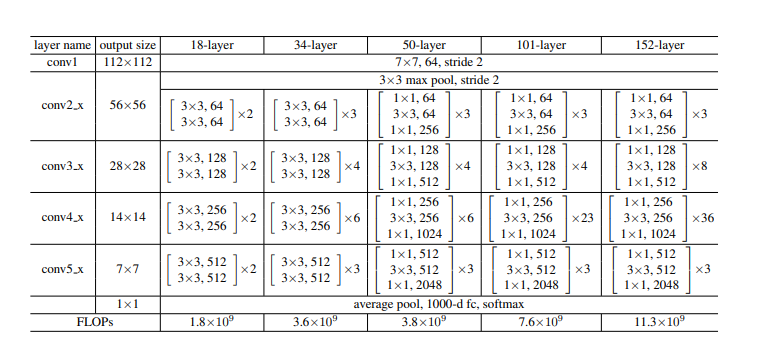

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')


    # we've made a 34 layer architecture
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIG["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

NameError: ignored

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

## Transfer Learning with EfficientNet

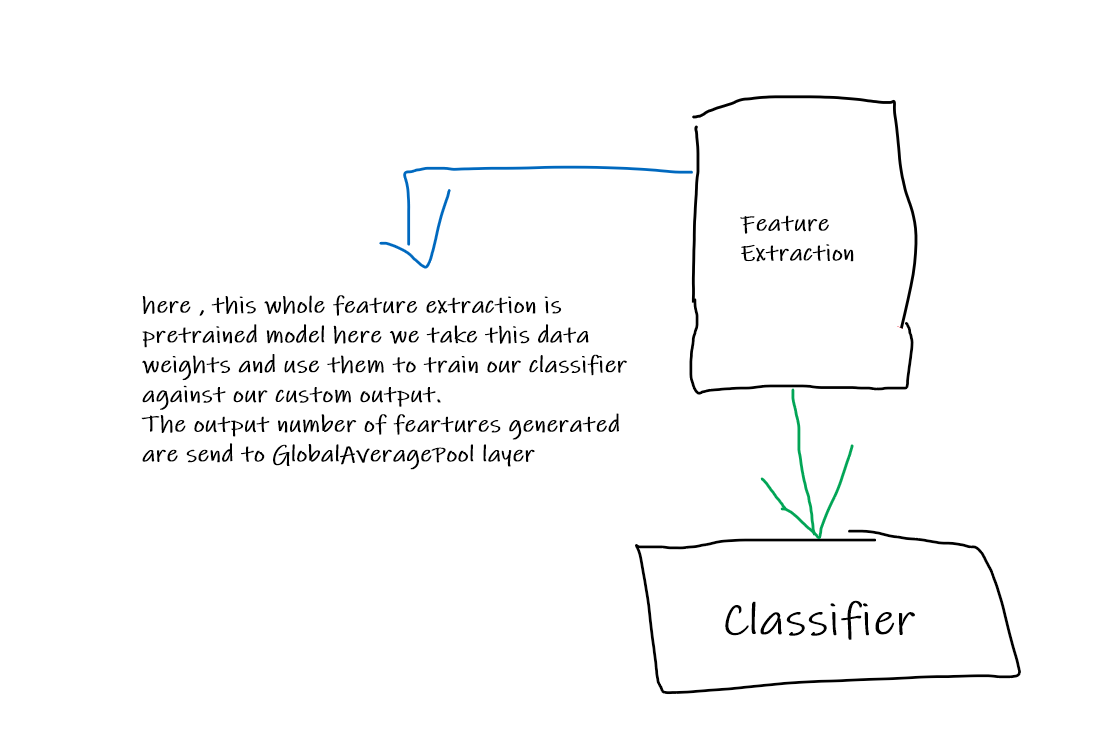

In [ ]:
# EfficientNet B4 is better than ResNet16 model , B4 is specific version of efficient net , it ranges from B0 to B6

backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights = 'imagenet',
    input_shape  = (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3)
)

# include_top = False ,means we don't wanna make a fully connected layer , now our fully connected layer converts the input to itself into flattened array
# now flattened is different layer , and it has nothing to do with fully connected layer , but what our FC is convert the given features into the required number of output class, i.e, in our case we need 3 classes , happy , sad and angry
# by setting it to false we mean that we just need the output number of features from the last conv layer as it is we don't need it to be converted into flattened format

# weights are from the pretrained image net model



71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
# trainable means a lot , in when we talk about efficient net we talk about , FEATURE EXTRACTION(FE) and CLASSIFICATION(classifier(C))
# now the pretrained model is our FE and this FE and if we just use the FE as it is i.e, not making our own trainable weights then we say trainable =False
# and if we want to configure our FE then we set trainable = True

backbone.trainable = False


In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3)),
    backbone,
    # here comes classifier although we should've made a seperate class of it , but there's no point as we are not sending some parameters to be passed to __call__ , all params here are predefined
    GlobalAveragePooling2D(),
    Dense(CONFIG["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense(CONFIG["N_DENSE_2"], activation = "relu"),
    Dense(CONFIG["NUM_CLASSES"], activation = "softmax"),
])
pretrained_model.summary()


# below we can see we only have 180k trainable params which are from classifier rest are all from Feature Extraction


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_40 (Dense)            (None, 100)               128100    
                                                                 
 batch_normalization_47 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_41 (Dense)            (None, 10)                1010      
                                                      

## Transfer Learning with MobileNetV2

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights = "imagenet",
    input_shape = (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3),
)


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIG["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIG["N_DENSE_2"], activation = "relu"),
    Dense( CONFIG["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_9 (Dense)             (None, 100)               128100    
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                      

## FineTuning EficientNet

* Fine-tuning specifically refers to a technique called transfer learning
* Transfer learning involves leveraging the knowledge gained from training a pre-existing model on a large dataset and applying it to a different but related task or dataset

* Fine-tuning in machine learning typically involves taking a pre-trained model and adjusting its weights or parameters on a new dataset to improve its performance on a specific task
* This process allows the model to adapt and specialize to the new data while retaining the general knowledge learned from the pre-training phase.


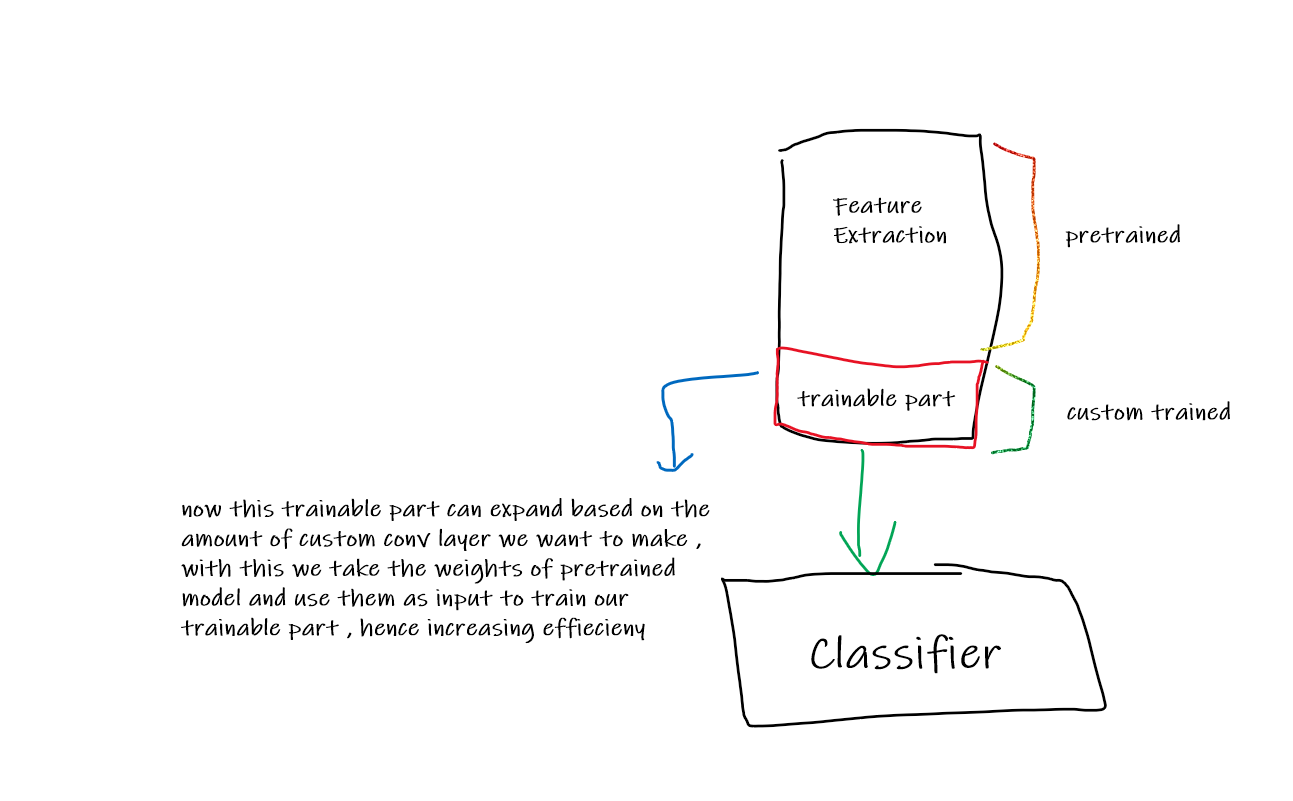

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"],3) )

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIG["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(CONFIG["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIG["NUM_CLASSES"], activation = "softmax")(x)
finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 100)               128100    
                                                                 
 batch_normalization_46 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                             

# VITS(Vision Tranformers)

## Patch Encoder


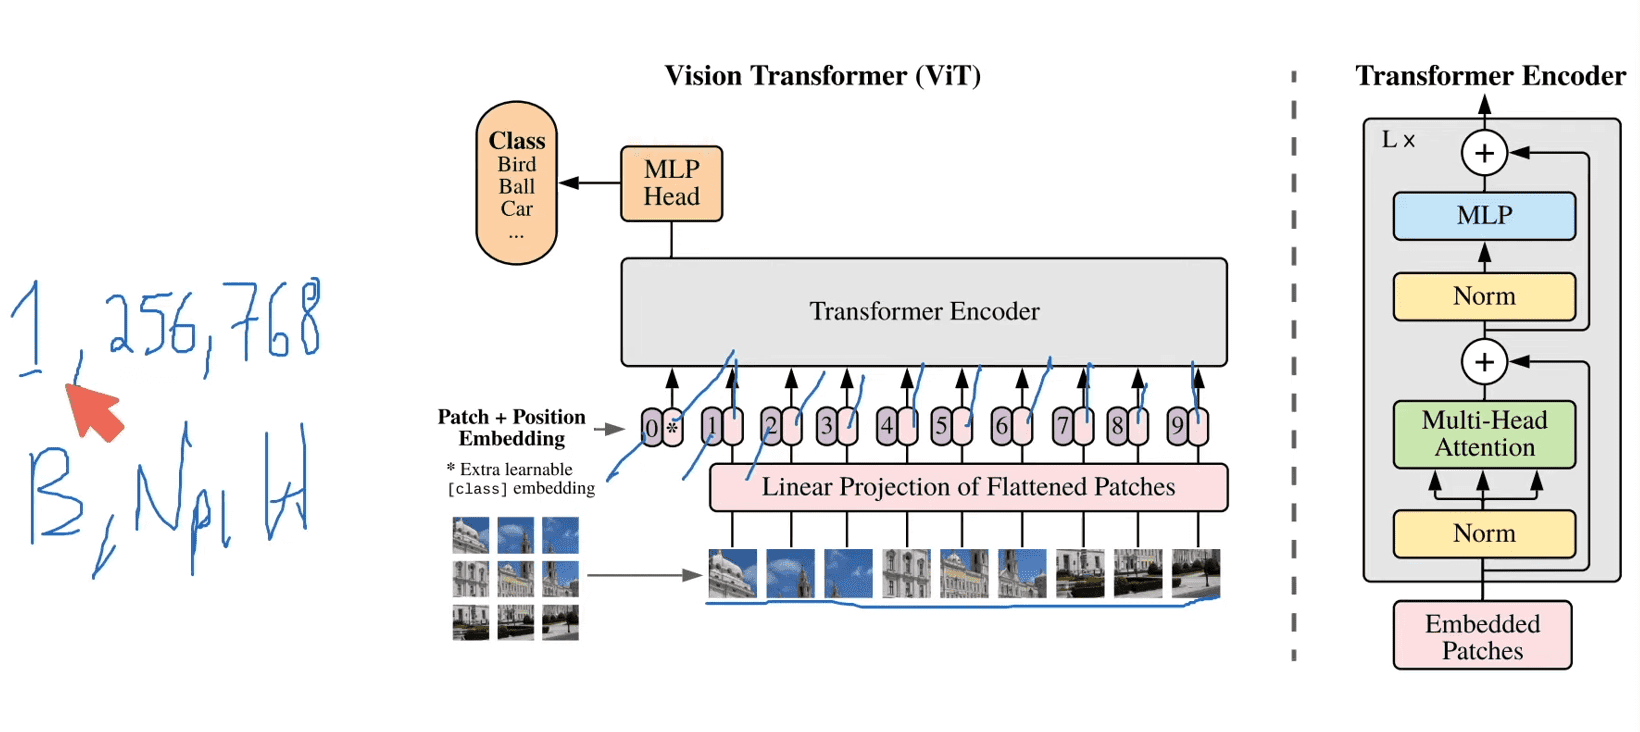

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
print(test_image.shape)
test_image = cv2.resize(test_image, (CONFIG["IM_SIZE"] ,CONFIG["IM_SIZE"]))

(90, 90, 3)


In [ ]:
print(test_image.shape)

(256, 256, 3)


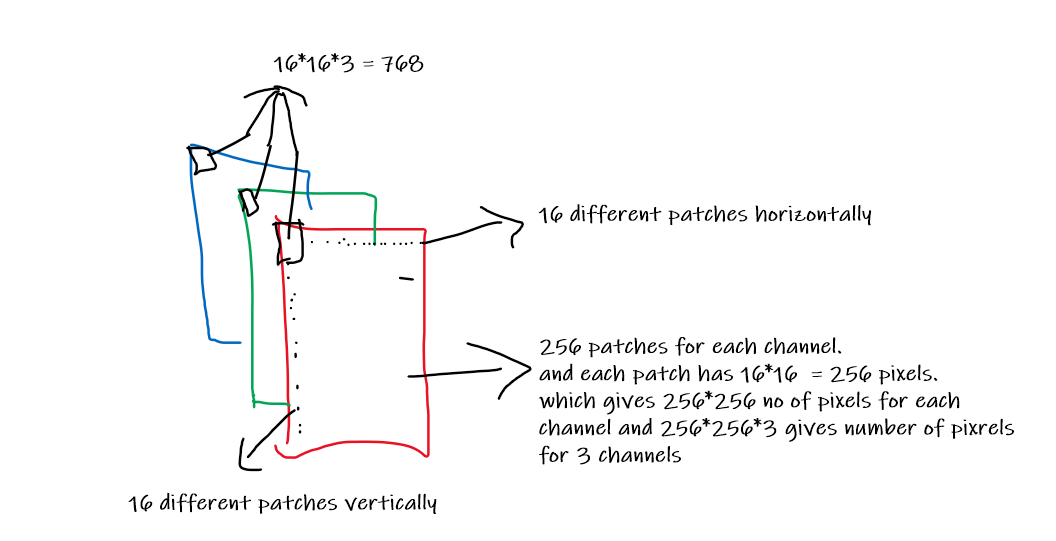

In [ ]:
# creating patches out of image, below is sample of transforming an image into patches
patches = tf.image.extract_patches(images = tf.expand_dims(test_image, axis=0),
                                   sizes = [1, CONFIG["PATCH_SIZE"], CONFIG["PATCH_SIZE"], 1],
                                   strides =  [1, CONFIG["PATCH_SIZE"], CONFIG["PATCH_SIZE"], 1],
                                   rates=[1,1,1,1],
                                   padding='VALID'
                                   )
# strides are equal to patch size because we want the patches to not overlap , hence our consecutive patches will cover different section of images
# since our number of chanels for original image are 3 and for each patch the the size is 16*16=256 so 256*3 = 768 hence o/p channels will be 768

In [ ]:
print(patches.shape)
# either we can specify 256 at number height(h=256, w=768) or -1 which takes both 16*16 =256
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


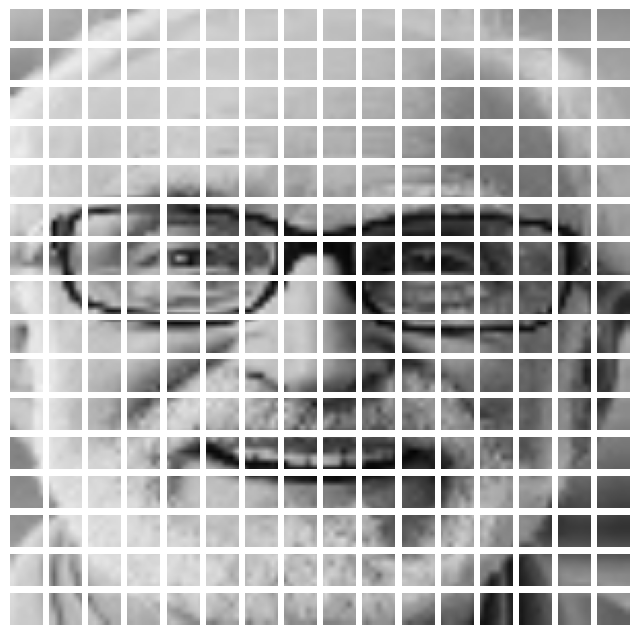

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  # number of patches are the patches we want to create and hidden_size are the vectors which are multiplied by patches vector to get relative position of patches
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images = x,
        sizes = [1, CONFIG["PATCH_SIZE"], CONFIG["PATCH_SIZE"], 1],
        strides = [1, CONFIG["PATCH_SIZE"], CONFIG["PATCH_SIZE"], 1],
        rates = [1,1,1,1],
        padding='VALID',
    )
    # here we just reshaped the patches , to reshape we've patches -> to reshape we take previous patches shape 0 the index , 256 , and last index of patches.shape
    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    # since we've done with patches now we need to do embeddings to get the relationship between each patch to another corresponding patch
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    # output should be linear projections, i.e, combination of the patch with embedding and these patches are put into the transformer Enconder after attaching some
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)
    return output

In [ ]:
# patcher = PatchEncoder(256, 768)
# patcher(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[-0.01857913,  0.01723224,  0.03899319, ..., -0.0298241 ,
          0.00308691, -0.03773963],
        [ 0.02227366,  0.04496235, -0.01783124, ..., -0.03902461,
         -0.02279385, -0.03033513],
        [ 0.02727176,  0.04574616,  0.04311855, ...,  0.01327989,
          0.01911006, -0.03537154],
        ...,
        [ 0.02815412, -0.03759459,  0.0187265 , ..., -0.03823502,
          0.04701469, -0.02028662],
        [-0.01369697,  0.00289387,  0.00565998, ..., -0.00236802,
          0.04689864,  0.04184571],
        [-0.03355964, -0.04502428,  0.04006876, ..., -0.00948119,
         -0.03232505, -0.0493488 ]]], dtype=float32)>

## Transormer Encoder

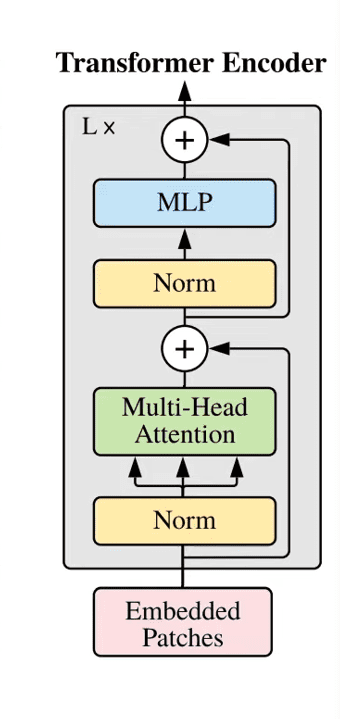

In [ ]:
class TransformerEncoder(Layer):
  #  hidden size are the extra learnable embedding or positional embedding (which are multiplied by the output vector/patch by linear projection) which specify the spatial relationship between the patches
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    # In transformer-based models such as ViT, the self-attention mechanism allows the model to focus on different parts of the input sequence simultaneously. Each attention head attends to different parts of the input sequence, capturing different dependencies and relationships
    # The number of heads in a transformer model determines the model's capacity to capture different types of dependencies and patterns in the input data. Increasing the number of heads allows the model to capture more fine-grained relationships and potentially improve its performance on complex tasks. However, increasing the number of heads also increases the computational cost and memory requirements of the model.
    # N_HEADS =4 , HIDDEN_SIZE=768
    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    # here we two input to multihead , actually we have to have 3 which are Query , Key and , Value , but here two are Query and Value , since key is not specified so we can say that Value = Key
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

In [ ]:
# trans_encoder = TransformerEncoder(4, 768)
# trans_encoder(tf.zeros([1,256,768]))z

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [ ]:
# double parenthesis is required cause we need to pass arguements to layers

#
# We cannot pass the output of a previous layer inside the first parenthesis because the first parenthesis is used to pass the input tensor to the method. The input tensor is the data that the method will operate on.

# If we were to pass the output of a previous layer inside the first parenthesis, then the method would not know what data to operate on. This would cause an error.

class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    # here we want L(times) number of encoder , i.e, the encoder is repeated for number of layers times and thef we create loop to iterate over the number of transformer encoder
    # here we are just making encoder 2 timese only since our N_LAYERS=2
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIG["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      # x stores every transformer encoder return value
      x = self.trans_encoders[i](x)
    # since from  our diagram we can clearly see that we need one single output so we need to flatten the various output generated by transformer encoder
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.4831131 , 0.18776609, 0.32912076],
       [0.48311284, 0.18776615, 0.329121  ]], dtype=float32)>

In [ ]:
# vit = tf.keras.applications.ViT('vit_b16')
# config = vit.get_config()
# new_vit = tf.keras.models.model_from_config(config)
# new_vit.summary()

# OR

# vit = tf.keras.applications.ViT('vit_b16')
# vit.save_config('vit_config.json')

# new_vit = tf.keras.models.load_config('vit_config.json')
# new_vit.summary()

In [ ]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 dense_5 (Dense)             multiple                  25165952  
                                                                 
 dense_6 (Dense)             multiple                  16512     
                                                

## HuggingFace ViT
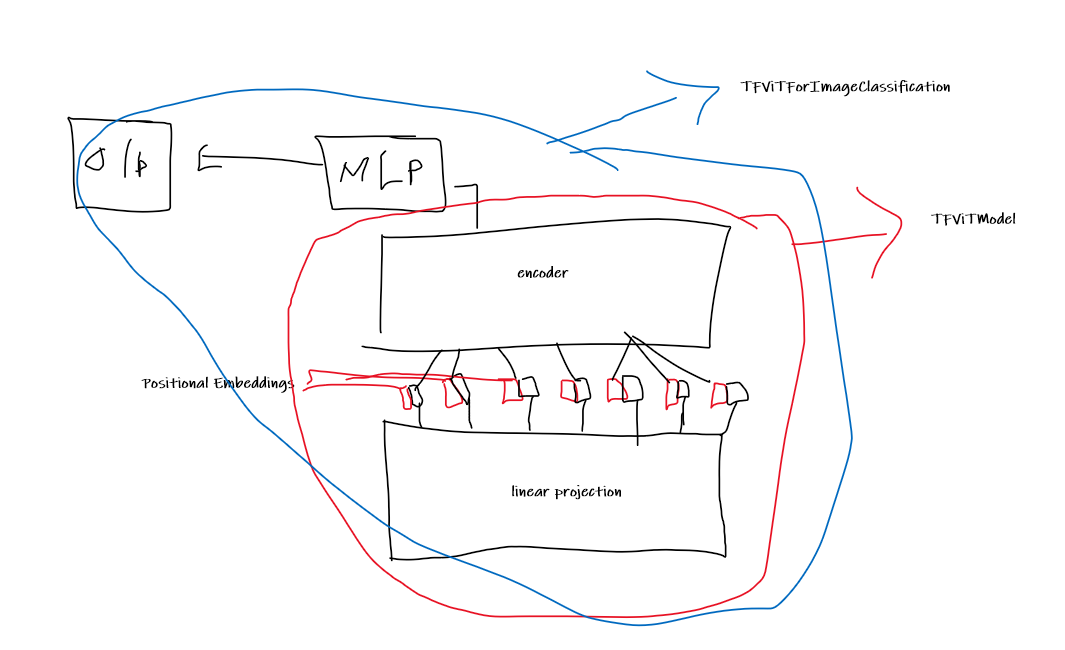

In [ ]:
!pip install transformers

### Training

In [ ]:
# ( hidden_size = 768num_hidden_layers = 12num_attention_heads = 12intermediate_size = 3072hidden_act = 'gelu'hidden_dropout_prob = 0.0attention_probs_dropout_prob = 0.0initializer_range = 0.02layer_norm_eps = 1e-12image_size = 224patch_size = 16num_channels = 3qkv_bias = Trueencoder_stride = 16**kwargs )

# Parameters

# hidden_size (int, optional, defaults to 768) — Dimensionality of the encoder layers and the pooler layer.
# num_hidden_layers (int, optional, defaults to 12) — Number of hidden layers in the Transformer encoder.
# num_attention_heads (int, optional, defaults to 12) — Number of attention heads for each attention layer in the Transformer encoder.
# intermediate_size (int, optional, defaults to 3072) — Dimensionality of the “intermediate” (i.e., feed-forward) layer in the Transformer encoder.
# hidden_act (str or function, optional, defaults to "gelu") — The non-linear activation function (function or string) in the encoder and pooler. If string, "gelu", "relu", "selu" and "gelu_new" are supported.
# hidden_dropout_prob (float, optional, defaults to 0.1) — The dropout probability for all fully connected layers in the embeddings, encoder, and pooler.
# attention_probs_dropout_prob (float, optional, defaults to 0.1) — The dropout ratio for the attention probabilities.
# initializer_range (float, optional, defaults to 0.02) — The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
# layer_norm_eps (float, optional, defaults to 1e-12) — The epsilon used by the layer normalization layers.
# image_size (int, optional, defaults to 224) — The size (resolution) of each image.
# patch_size (int, optional, defaults to 16) — The size (resolution) of each patch.
# num_channels (int, optional, defaults to 3) — The number of input channels.
# qkv_bias (bool, optional, defaults to True) — Whether to add a bias to the queries, keys and values.
# encoder_stride (int, optional, defaults to 16) — Factor to increase the spatial resolution by in the decoder head for masked image modeling.
# This is the configuration class to store the configuration of a ViTModel. It is used to instantiate an ViT model according to the specified arguments, defining the model architecture. Instantiating a configuration with the defaults will yield a similar configuration to that of the ViT google/vit-base-patch16-224 architecture.

# Configuration objects inherit from PretrainedConfig and can be used to control the model outputs. Read the documentation from PretrainedConfig for more information.


# intermediate_size in transfromers.ViTConfig define the intermediate dense layer , i.e, in MLP in TE not MLP Head , we have to have 2 dense layer , the first one take the input from layer norm and second produce the o/p no of channels
# so the first dense layer take input feature and expand the number of channels within it , then send to dense_2 which reduce the channel back to normal


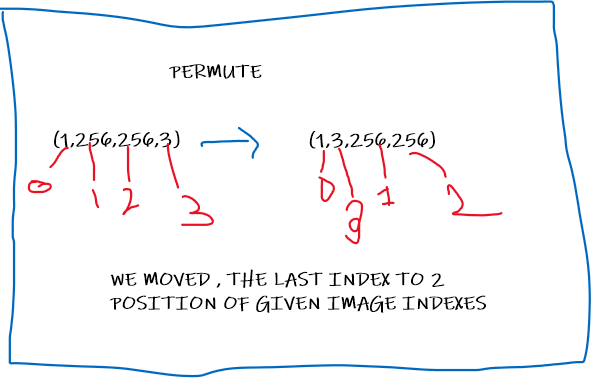

In [ ]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224,224),
    Rescaling(1./255),
    Permute((3,1,2))
])

In [ ]:
from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig()

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.31.0"
}



In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# the input to the hugging face model neds image format of (3,256,256) , i,e height and width at last hence we reshaped the image , and transform the last index of the image  (256,256,3) 3 to the first position (3,256,256)
inputs = Input(shape = (256,256,3))

x = resize_rescale_hf(inputs)
print(x, "before")
x = base_model.vit(x)[0][:,0,:]
print(x,"after")
#print(x)
output = Dense(CONFIG["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)


All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), name='sequential/permute/transpose:0', description="created by layer 'sequential'") before
KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'") after


In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIG["IM_SIZE"] ,CONFIG["IM_SIZE"]))

In [ ]:
# with this model will get output with last_hidden_state, pooler_output, meanwhile hidden_states and attentions
hf_model(tf.expand_dims(test_image, axis=0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.39763984, 0.34531736, 0.2570428 ]], dtype=float32)>

In [ ]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]
loss_function = CategoricalCrossentropy(from_logits = False)

In [ ]:
pretrained_model.compile(
    metrics = metrics,
    loss = loss_function,
    optimizer=Adam(learning_rate = CONFIG["LEARNING_RATE"])
)

hf_model.compile(
    metrics = metrics,
    loss = loss_function,
    optimizer=Adam(learning_rate = CONFIG["LEARNING_RATE"])
)

In [ ]:
history = pretrained_model.fit(train_dataset,validation_data = val_dataset, epochs =CONFIG["N_EPOCHS"])

Epoch 1/20
102/213 [=============>................] - ETA: 3:58 - loss: 0.9804 - accuracy: 0.5276 - top_k_accuracy: 0.7984

KeyboardInterrupt: ignored

In [ ]:
# model evaluation require model compilation , cause compile specify the loss , metrics and optimizer, without that evaluate won't print results
hf_model.evaluate(val_dataset)

 2/72 [..............................] - ETA: 45:09 - loss: 1.1257 - accuracy: 0.2812 - top_k_accuracy: 0.6250

### Get Attention Maps

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig


# ViTConfig is a function
configuration  = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


# ONNX

*   ONNX is an open format built to represent machine learning models. ONNX defines a common set of operators - the building blocks of machine learning and deep learning models - and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers


In [ ]:
# QUANTIZATION --> is technique of performing computations and storing tensors at lower bit widths then usual floating values
# STATIC QUANTIZATION --> we compute the quantization for much smaller data(calibration data), in this we take an input pass through the model having params then perform several runs and finally gets most appropriate weights.
#  Here we get the quantization params already before ,with help of calibration data , running inference we already have our quan param set . but if we do calibration poorly (using bad values for scale and zero point) then our quant param perform poorly
# DYNAMIC QUANTIZATION --> we compute the quantization params at each run using scale and zero point

# scale and zero point are the methods which calculate the quant params ,

In [ ]:
hf_model.save('vit_finetuned.h5')

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import onnxruntime as rt
rt.get_device()

'GPU'

## Conversion

### From TensorFlow SavedModel

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

2023-07-27 15:14:46.157360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-07-27 15:14:49,105 - WARNING - '--tag' not specified for saved_model. Using --tag serve
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/tf2onnx/convert.py", line 710, in <module>
    main()
  File "/usr/local/lib/python3.10/dist-packages/tf2onnx/convert.py", line 242, in main
    graph_def, inputs, outputs, initialized_tables, tensors_to_rename = tf_loader.from_saved_model(
  File "/us

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model_for_export, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

In [ ]:
output_names = ['dense']

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
N_PREDICTIONS = 10

In [ ]:
providers=['CPUExecutionProvider' ]
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
t1 = time.time()

for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(['dense'], {"input": im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

In [ ]:
print(onnx_pred)

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

In [ ]:
# tf, gpu = 0.15s
# tf, cpu = 0.8s
# tf_size = 1000MB

# onnx, cpu = 0.5s
# onnx, gpu = 0.025s
# onnx_size = 328MB

# onnx_quantized, cpu = 0.4s
# onnx_quantized, gpu = 0.3s
# onnx_quantized_size = 83MB

## Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/eff_keras.onnx'
model_quant = '/content/eff_quantized.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

In [ ]:
!pip install onnxruntime

In [ ]:
import onnxruntime as rt

In [ ]:
providers=['CPUExecutionProvider' ]
m_q = rt.InferenceSession("/content/drive/MyDrive/Bang/eff_quantized.onnx", providers=providers)

In [ ]:
onnx_pred = m_q.run(['dense'], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

# fastapi==0.87.0
# numpy==1.23.4
# onnxruntime==1.13.1
# Pillow==9.3.0

In [ ]:
!pip install onnxruntime==1.13.1

# Quantization in TensorFlow

### INSTALLATION AND IMPORTS

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

In [ ]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

In [ ]:
pretrained_model.summary()

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_eff.summary()

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

## Post Training Quantization

In [ ]:
pretrained_model.load_weights("/content/drive/MyDrive/Bang/eff_keras.h5")

In [ ]:
pretrained_model.evaluate(validation_dataset)

In [ ]:
def representative_data_gen():
  for input_value,j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

In [ ]:
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
pretrained_model.save("eff_model.h5")

### TFLIte Runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [ ]:
import tflite_runtime as tflite
import numpy as np
import cv2

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
test_image = np.expand_dims(test_image, axis = 0)

#print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

In [ ]:
interpreter = tflite.Interpreter(model_path="/content/drive/MyDrive/Bang/eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]


In [ ]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

### Accuracy of Quantized Model

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy("/content/drive/MyDrive/Bang/eff_model.tflite")

# RUNNING MODEL

**LOSS**

In [ ]:
loss_function = CategoricalCrossentropy(from_logits = False)

In [ ]:
y_true=[[1,0,0],[1,0,0]]

y_true_sparse=[0,0] # for above and if [1,0,0] -> 0 , [0,1,0]-> 1, [0,0,1]-> 2

y_pred = [[0.01, 0.05, 0.96], [0.1, 0.2,0.7]]

cce = tf.keras.losses.CategoricalCrossentropy()
cce_sparse = tf.keras.losses.SparseCategoricalCrossentropy()

print("SPARSE", cce_sparse(y_true_sparse, y_pred).numpy())
print("NORMAL", cce(y_true, y_pred).numpy())


# closer the value to 0 the more acurate model is

SPARSE 3.463779
NORMAL 3.463779


**METRICS [accuracy]**

In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

**COMPILING**

In [ ]:
seq_model.compile(
    metrics = metrics,
    loss = loss_function,
    optimizer=Adam(learning_rate = CONFIG["LEARNING_RATE"])
)

**SEQUENTIAL TRAINING**

In [ ]:
history = seq_model.fit(train_dataset,validation_data = val_dataset, epochs =CONFIG["N_EPOCHS"])

Epoch 1/5
213/213 [==============================] - 484s 2s/step - loss: 0.9429 - accuracy: 0.5663 - top_k_accuracy: 0.8157 - val_loss: 0.9860 - val_accuracy: 0.5219 - val_top_k_accuracy: 0.8147
Epoch 2/5
213/213 [==============================] - 593s 3s/step - loss: 0.6651 - accuracy: 0.7229 - top_k_accuracy: 0.9101 - val_loss: 0.8840 - val_accuracy: 0.6111 - val_top_k_accuracy: 0.8464
Epoch 3/5
213/213 [==============================] - 503s 2s/step - loss: 0.4625 - accuracy: 0.8188 - top_k_accuracy: 0.9485 - val_loss: 0.7391 - val_accuracy: 0.7081 - val_top_k_accuracy: 0.8916
Epoch 4/5
213/213 [==============================] - 441s 2s/step - loss: 0.3013 - accuracy: 0.8916 - top_k_accuracy: 0.9781 - val_loss: 0.8155 - val_accuracy: 0.6936 - val_top_k_accuracy: 0.8832
Epoch 5/5
213/213 [==============================] - 482s 2s/step - loss: 0.2055 - accuracy: 0.9332 - top_k_accuracy: 0.9862 - val_loss: 0.8767 - val_accuracy: 0.6642 - val_top_k_accuracy: 0.8819


# PLOTTING AND TESTING

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

NameError: ignored

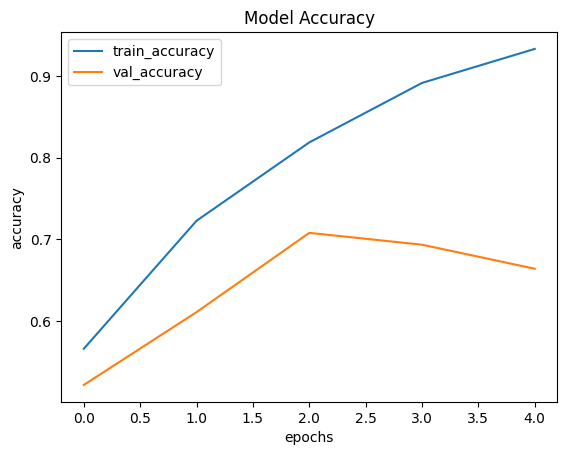

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train_accuracy", "val_accuracy"])
plt.show()

In [ ]:
seq_model.evaluate(val_dataset)

72/72 [==============================] - 44s 606ms/step - loss: 0.8767 - accuracy: 0.6642 - top_k_accuracy: 0.8819


[0.8767092823982239, 0.6641790866851807, 0.881913959980011]

In [ ]:
test_image = cv2.imread("/content/dataset/EmotionsDataset/data/happy/1002.jpg")
im = tf.constant(test_image, dtype=tf.float32)
print(im.shape)

im = tf.expand_dims(im, axis=0)

print(Class_Names[tf.argmax(seq_model(im), axis=-1).numpy()[0]])

(224, 224, 3)
happy


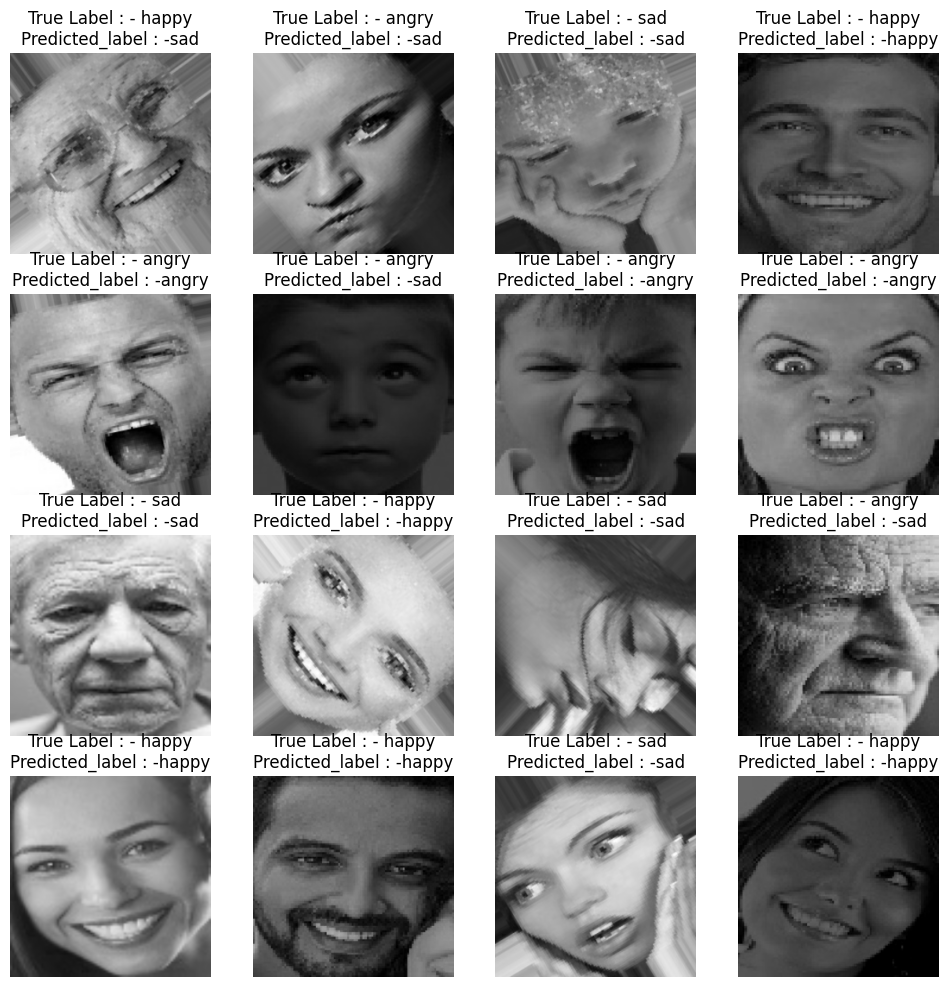

In [ ]:
# print(val_dataset.take(1))
plt.figure(figsize=(12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax= plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label : - "+ Class_Names[tf.argmax(labels[i], axis=0).numpy()]+ "\n" + "Predicted_label : -" + Class_Names[tf.argmax(seq_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0]])
    plt.axis("off")
    # plt.axis("off") will not print the number value for the plot since our plot ia always graphical.


#### **Confusion Matrix**



In [ ]:
predicted = []
labels = []
for images , label in val_dataset:
  predicted.append(lenet(images))
  labels.append(label.numpy())

KeyboardInterrupt: ignored

In [ ]:
# here for our labels and predicted we've values which are up until the last batch i.e consider data of 98 elements and we've batch of 32 so 32*3 is 96 and we are left with 2 elements
# below we are excluding the remaining elements , but we've to consider those
# actual = np.argmax(labels[:-1], axis=-1).flatten()

# now here we are concatinating the values , 1). all the batch ecluding the last which have incomplete values, 2). is the last values

actual = np.concatenate([np.argmax(labels[:-1], axis=-1).flatten(), np.argmax(labels[-1] , axis=-1).flatten()])
pred = np.concatenate([np.argmax(predicted[:-1], axis=-1).flatten(), np.argmax(predicted[-1], axis=-1).flatten()])

# here we've used a numpy argmax method because the flatting in tensorflow is done using tf.reshape which i don't know how to use

In [ ]:
print(actual , pred)

[2 1 0 ... 2 2 1] [2 1 0 ... 1 2 2]


[[262  77 176]
 [ 88 644 274]
 [ 77  73 607]]


Text(0.5, 58.7222222222222, 'Predicted')

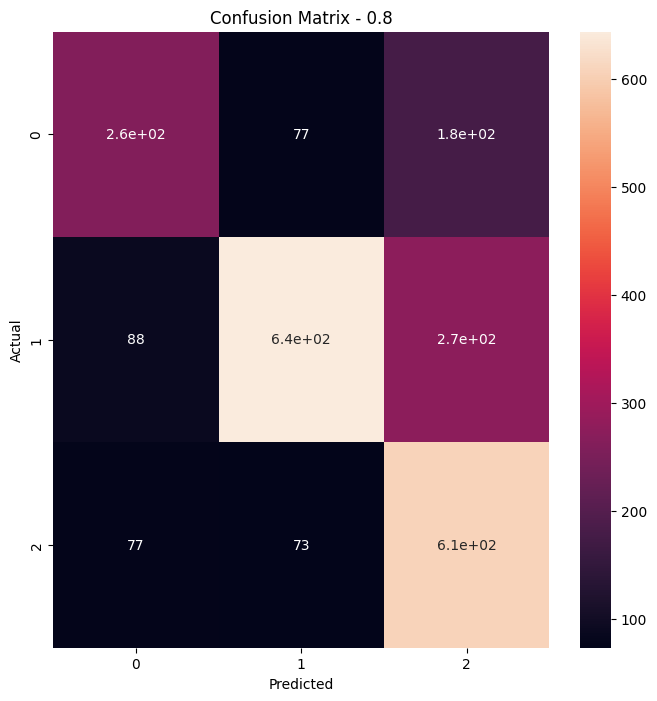

In [ ]:
threshold =0.8
cm = confusion_matrix(actual, pred)
print(cm)
plt.figure(figsize=(8,8))


sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix - {}".format(threshold))
plt.ylabel("Actual")
plt.xlabel("Predicted")

# in confusion matrix , the lighter the color the higher the value and is opposite for dark

# plotting feature maps

In [ ]:
# creating a VGG backbone or Feature Extraction to get the feature maps model

vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape= (CONFIG["IM_SIZE"], CONFIG["IM_SIZE"], 3)
)


In [ ]:
# with this loop we are removeing the pooling layer and taking just conv layers from the Feature Extraction
def check_conv(layer_name):
  if "conv" in layer_name :
    return True
  else:
    return False

In [ ]:
# here vgg_backbone.layers will give all layers , that in our case is 18 --> 5 pool and 13 conv, we start from [1:] such that we can avoid the input layer
#  and since we are only extracting the conv layer hence we return values of only conv layers and not pool
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if check_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps,
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
test_image = cv2.imread("/content/dataset/EmotionsDataset/data/happy/1002.jpg")
test_image = cv2.resize(test_image, ( CONFIG["IM_SIZE"], CONFIG["IM_SIZE"]))


im = tf.constant(test_image, dtype=tf.float32)
print(im.shape)
im = tf.expand_dims(im, axis=0)

f_maps = feature_map_model.predict(im)

(256, 256, 3)
1/1 [==============================] - 1s 1s/step


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize=(256,256))
  # f-size select the i'th array's (1,256,256,3) first value i.e, at 0 index we've one and at 1 index we've 256 then at 2->width->256 , 3->no of channels-> 8
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  # essentially what joint maps is doing , is it takes the channel which are in stack order i.e, one behind other to the queue order i.e, side by side to each othere
  joint_maps = np.ones((f_size, f_size*n_channels))
  # now the np.ones first index represent the height which should be equal to the initial height as we are not stacking images on top of each other but side by side so we need to change the widht not height
  # for height since we queue'd them hence the channels which represent the number of maps now is useful to count the total widht ->widht * channels
  axs = plt.subplot(len(f_maps), 1 , i+1)
  for j in range(n_channels):
    # here we are taking range that start from 0 , so we've 2 values int joint_maps,first is the height --> we are selecting height since our joint_maps contain height at 0 and width at 1  second is the width selection -->  before : signifies --> with the starting width of the image and after : signifies --> is the ending width of the image. We know for first image the width must start from zero and end at width length of the image
    #, for second image the width start from the ending width of the first image(for second image it must be the width specified of image as the first image must be (0 == f_size*(j) when j==0,256 == f_size*(j+1)*2 , when j==0) width and second is (256 = f_size*(j) when j==1, 512 == f_size*(j+1)*2, when j==2) same we do for all images)

    # now for our f_maps[i][..., j] , we means we are selecting every value i.e, for (1,64,64,256) -> ... means (1,64,64) and the j is 0 initially which select the first output feature map  out of the 256 and so on we increement the j to get all 256 channels
    # now the equal = signify that we are storing the first or consecutive j feature map in the joint_maps and our feature map is 2D array remember ?
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

# showing all images will be ram consuming hence we select the first 52 images
  plt.imshow(joint_maps[:, 0:512])
  plt.axis("off")